#### Importing libraries

In [62]:
# import required packages
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from scipy.stats import skew
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')

#### Loading data

In [63]:
# mount drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [64]:
df = pd.read_csv("/content/gdrive/MyDrive/MCS/CSI5155/Assignment1/marketing_campaign.csv", sep="\t")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [65]:
df.Complain.value_counts()

0    2219
1      21
Name: Complain, dtype: int64

#### Data Cleaning

In [66]:
print("Shape of the data frame = ", df.shape, "\n")
# checking if there's any object type column in the dataset (Education, Marital_Status, Dt_Cuustomer)
df.info()

Shape of the data frame =  (2240, 29) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15

In [67]:
# calculating total null values per column
print(df.isnull().sum())
# Identify and dropping missing values as it's just 0.01% of the whole dataset
df.dropna(inplace=True)

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64


In [68]:
# checking for duplicate rows if any
duplicate_rows = df[df.duplicated()]
print("Number of duplicated rows = ", len(duplicate_rows))

Number of duplicated rows =  0


In [69]:
# checking for categorical columns and their unique values
for column in df.select_dtypes(include='object').columns:
  if column == "Dt_Customer":
    continue
  print(f"{column}: {df[column].unique()}")

Education: ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
Marital_Status: ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']


#### Feature Engineering

In [70]:
# One-hot encode Marital_Status
df = pd.get_dummies(df, columns=['Marital_Status'], drop_first=True)

In [71]:
# Label encode Education column (it might be ordinal)
label_encoder = LabelEncoder()
df['Education'] = label_encoder.fit_transform(df['Education'])

In [72]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
# making a new feature Time_Enrolment to record number of days (till today) since enrolment
df['Time_Enrolment'] = (pd.to_datetime('now') - df['Dt_Customer']).dt.days

In [73]:
df['Age'] = pd.to_datetime('now').year - df['Year_Birth']

In [74]:
# inventing a new feature "Total_Accepted_Campaigns" to count total campaigns accepted by a customer
df['Total_Accepted_Campaigns'] = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)

In [75]:
# Total Spending
df['TotalSpending'] = df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)

# Spending Ratios
# df['WinesRatio'] = df['MntWines'] / df['TotalSpending']
# df['FruitsRatio'] = df['MntFruits'] / df['TotalSpending']
# df['MeatRatio'] = df['MntMeatProducts'] / df['TotalSpending']
# df['FishRatio'] = df['MntFishProducts'] / df['TotalSpending']
# df['SweetsRatio'] = df['MntSweetProducts'] / df['TotalSpending']
# df['GoldRatio'] = df['MntGoldProds'] / df['TotalSpending']

In [76]:
df['Total_Purchases'] = df[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)
# purchases Ratios
# df['WebPurchasesRatio'] = df['NumWebPurchases'] / df['TotalSpending']
# df['CatalogPurchasesRatio'] = df['NumCatalogPurchases'] / df['TotalSpending']
# df['StorePurchasesRatio'] = df['NumStorePurchases'] / df['TotalSpending']

In [77]:
df = df.drop(['ID', 'Total_Purchases', 'TotalSpending', 'Year_Birth', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Marital_Status_YOLO', 'Marital_Status_Alone'], axis=1)
df.head()

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Complain,Response,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Time_Enrolment,Age,Total_Accepted_Campaigns
0,2,58138.0,0,0,58,635,88,546,172,88,...,0,1,0,0,1,0,0,4320,67,0
1,2,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,0,1,0,0,3474,70,0
2,2,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,0,0,1,0,3821,59,0
3,2,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,0,0,1,0,3414,40,0
4,4,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,1,0,0,0,3670,43,0


#### Train Test Split

In [78]:
y = df['Complain']
X = df.drop('Complain', axis=1)

In [79]:
# applying train-test split to avoid overfitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

#### Data Analysis

Number of people who complained in past 2 years =  16
Number of people who didn't complain in past 2 years =  1646


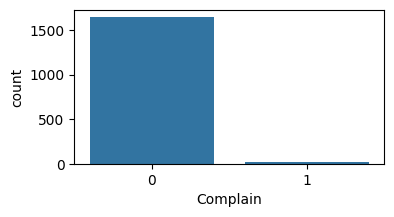

In [80]:
# Print the number of customers who complained and didn't complain
complained = y_train.value_counts()[1]
not_complained = y_train.value_counts()[0]

print("Number of people who complained in past 2 years = ", complained)
print("Number of people who didn't complain in past 2 years = ", not_complained)

plt.figure(figsize=(4, 2))
ax = sns.countplot(x=y_train)
# Add count labels on top of each bar
# for p in ax.patches:
#     ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

In [81]:
def plot_feature_distribution(x, y, feature: str):
  plt.figure(figsize=(6, 3))
  sns.histplot(x=x[feature], hue=y, element="step", common_norm=False, palette='magma', kde=True)
  plt.show()

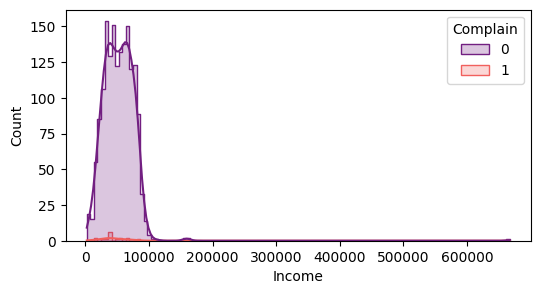

In [82]:
plot_feature_distribution(X_train, y_train, 'Income')

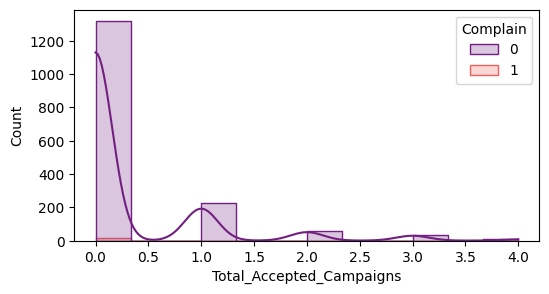

In [83]:
plot_feature_distribution(X_train, y_train, 'Total_Accepted_Campaigns')

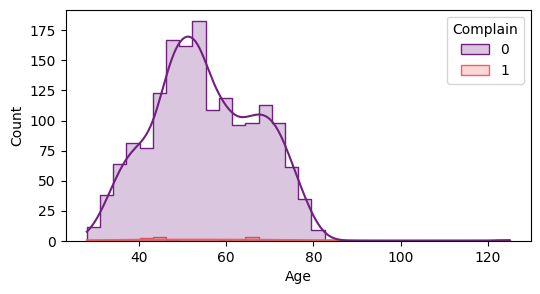

In [84]:
plot_feature_distribution(X_train, y_train, 'Age')

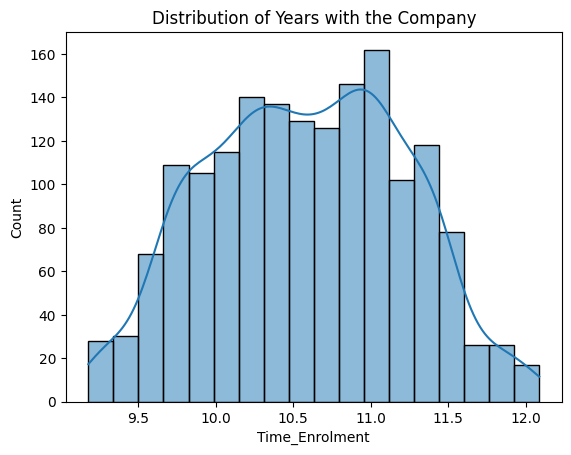

In [85]:
sns.histplot(X_train['Time_Enrolment']/365, kde=True)
plt.title('Distribution of Years with the Company')
plt.show()

In [86]:
X_train.corr()

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp2,Response,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Time_Enrolment,Age,Total_Accepted_Campaigns
Education,1.000000,0.114694,-0.043961,0.121125,0.003209,0.210071,-0.083388,0.030743,-0.120580,-0.100286,...,0.030799,0.082562,-0.015679,0.000237,0.002097,-0.017881,0.050368,-0.104650,0.182591,0.046757
Income,0.114694,1.000000,-0.409542,0.002809,-0.004816,0.555282,0.416523,0.555130,0.418651,0.425727,...,0.089736,0.105502,-0.005648,-0.017392,-0.028911,0.037232,0.029931,-0.021197,0.159308,0.287642
Kidhome,-0.043961,-0.409542,1.000000,-0.028740,0.005256,-0.496566,-0.385163,-0.441705,-0.382018,-0.381230,...,-0.086697,-0.076967,-0.000629,-0.003095,0.004359,0.026423,-0.066611,-0.066304,-0.226558,-0.202033
Teenhome,0.121125,0.002809,-0.028740,1.000000,0.010727,-0.010448,-0.196287,-0.283053,-0.209247,-0.174783,...,-0.023494,-0.144696,0.075504,0.012088,-0.103857,0.005125,0.052736,-0.005378,0.339622,-0.136999
Recency,0.003209,-0.004816,0.005256,0.010727,1.000000,0.032089,-0.004031,0.021262,0.002588,0.037407,...,-0.010569,-0.190094,-0.003909,-0.039533,0.028295,0.028631,-0.008073,-0.003394,0.031036,-0.003216
MntWines,0.210071,0.555282,-0.496566,-0.010448,0.032089,1.000000,0.382775,0.570399,0.393585,0.390277,...,0.206290,0.241075,-0.001466,-0.012573,-0.024487,0.019237,0.045282,0.149114,0.162768,0.516293
MntFruits,-0.083388,0.416523,-0.385163,-0.196287,-0.004031,0.382775,1.000000,0.551690,0.559599,0.579182,...,-0.017954,0.118281,-0.000973,-0.023101,0.012840,0.003126,0.030006,0.062965,0.024836,0.165996
MntMeatProducts,0.030743,0.555130,-0.441705,-0.283053,0.021262,0.570399,0.551690,1.000000,0.569508,0.535089,...,0.043799,0.225188,-0.037831,-0.023778,0.034706,0.016460,0.012828,0.068797,0.037076,0.305659
MntFishProducts,-0.120580,0.418651,-0.382018,-0.209247,0.002588,0.393585,0.559599,0.569508,1.000000,0.597921,...,-0.008051,0.087653,-0.042770,-0.032627,0.009502,0.031497,0.056071,0.068641,0.038668,0.180112
MntSweetProducts,-0.100286,0.425727,-0.381230,-0.174783,0.037407,0.390277,0.579182,0.535089,0.597921,1.000000,...,-0.000048,0.090520,-0.025223,-0.001600,-0.002868,0.002139,0.054275,0.078487,0.033822,0.178821


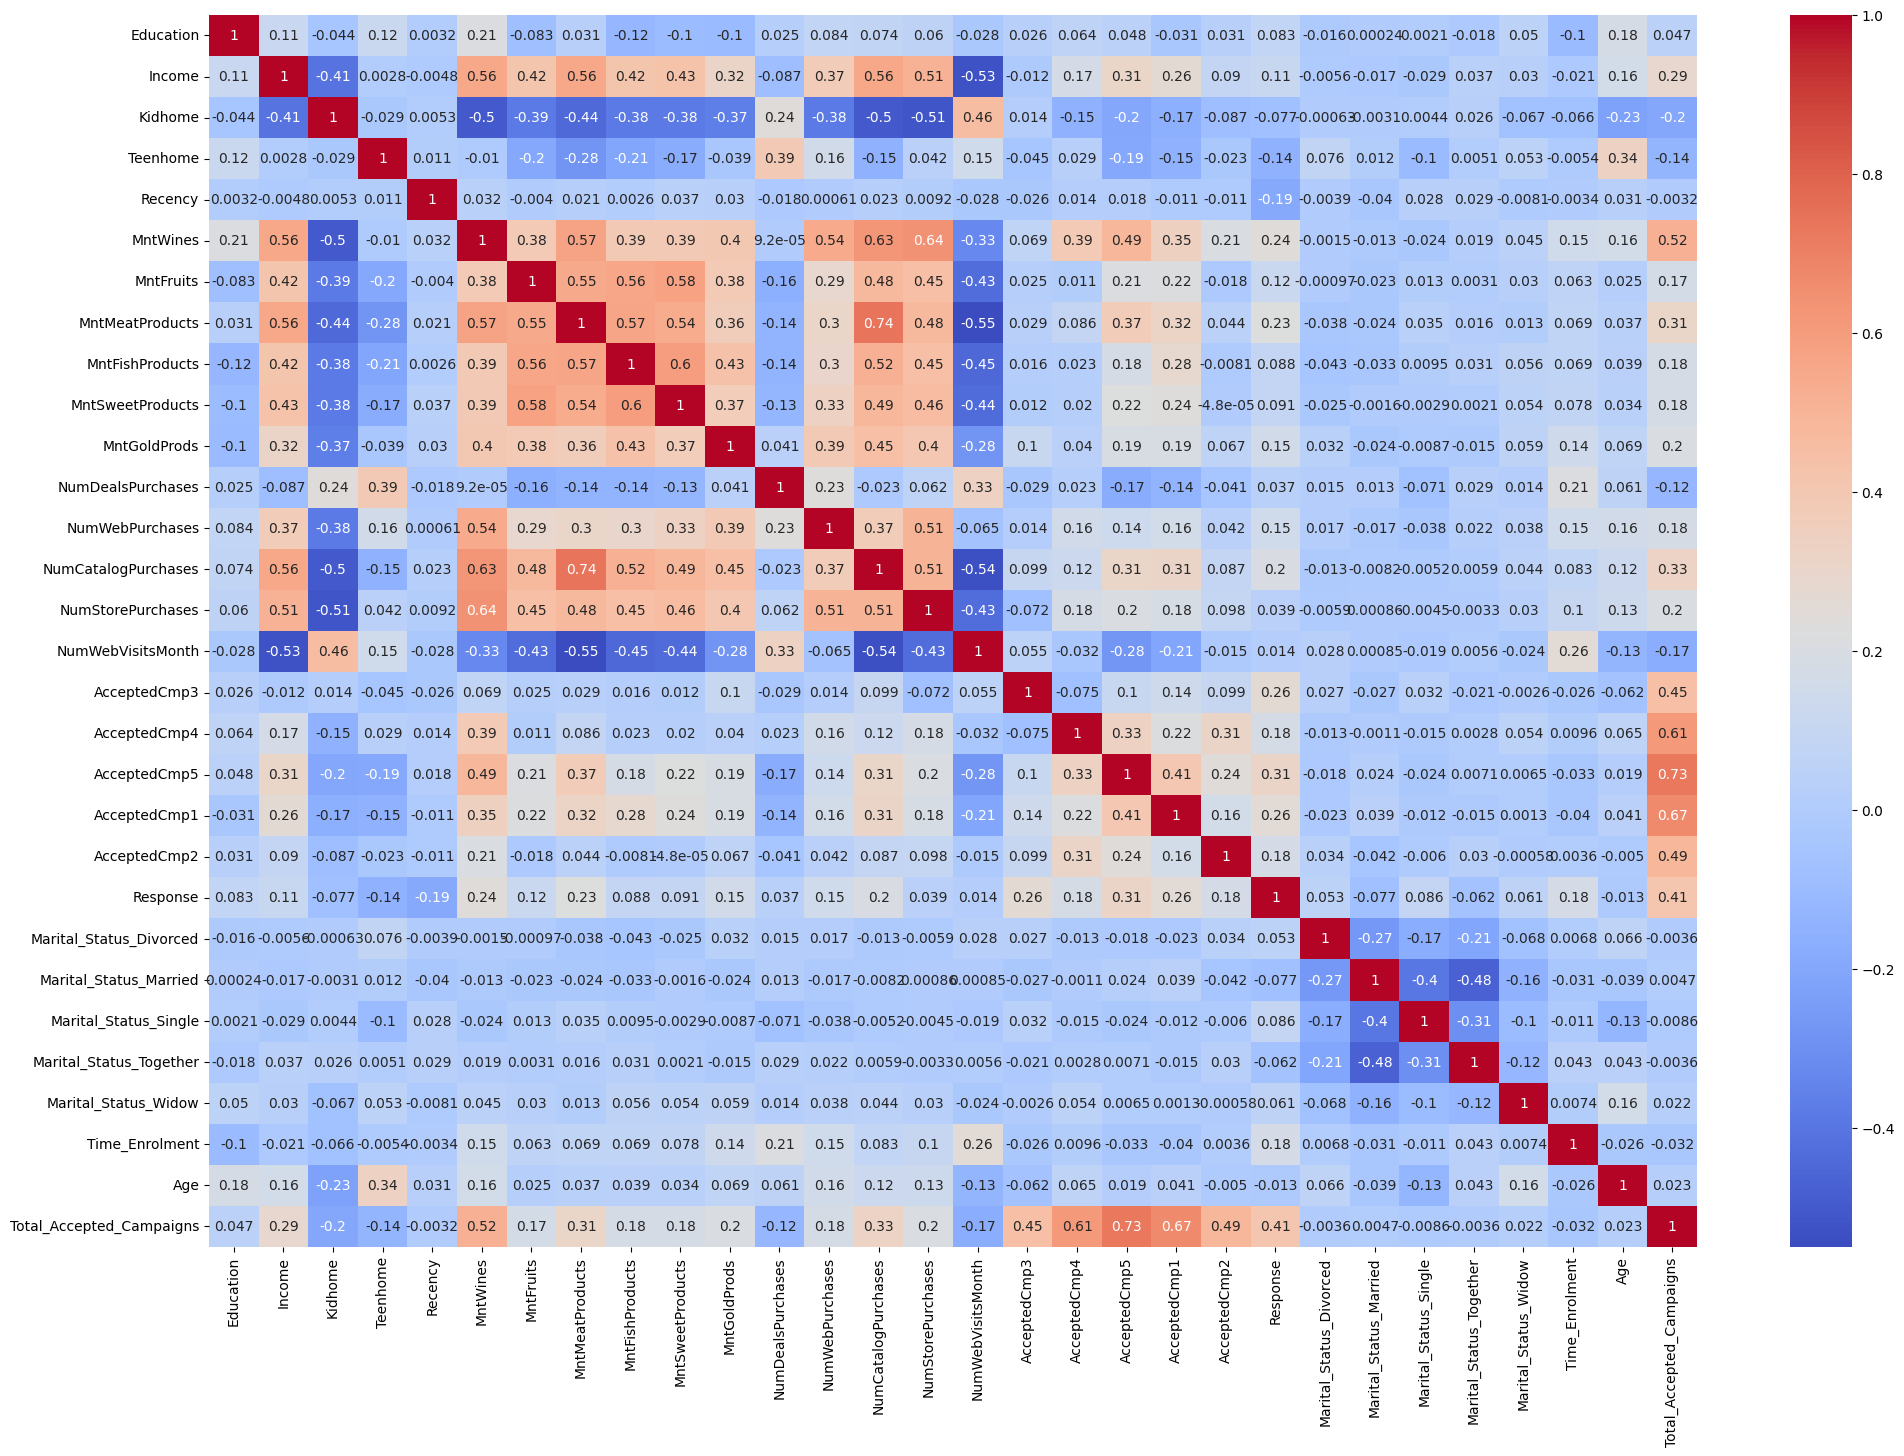

In [87]:
# correlation matrix heatmap
plt.figure(figsize=(24, 16))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [88]:
trainSkew = X_train.skew()
print((trainSkew.sort_values()))

Education                  -0.285322
Time_Enrolment             -0.006923
Recency                     0.007457
NumWebVisitsMonth           0.111550
Age                         0.289071
Teenhome                    0.392050
Marital_Status_Married      0.485854
Kidhome                     0.635927
NumStorePurchases           0.682019
Marital_Status_Together     1.046523
MntWines                    1.152502
NumWebPurchases             1.335755
Marital_Status_Single       1.470644
MntGoldProds                1.850651
MntFishProducts             1.961808
NumCatalogPurchases         1.972046
MntMeatProducts             1.997740
Response                    2.004496
MntSweetProducts            2.083197
MntFruits                   2.112608
NumDealsPurchases           2.347000
Marital_Status_Divorced     2.584708
Total_Accepted_Campaigns    2.821959
AcceptedCmp4                3.291445
AcceptedCmp5                3.343852
AcceptedCmp3                3.473660
AcceptedCmp1                3.636737
M

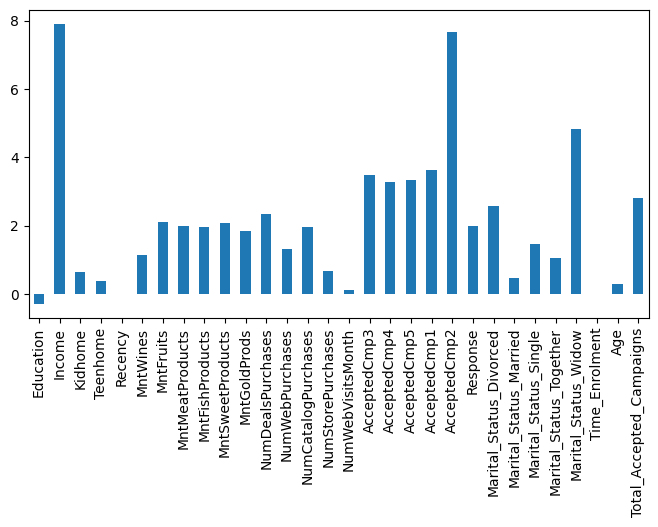

In [89]:
# plotting skewness in the dataset
plt.figure(figsize=(8, 4))
trainSkew.plot(kind='bar')
plt.show()

#### Feature Transformations

In [90]:
scaler = MinMaxScaler()

# Fit and transform on training data
X_train_normalized = scaler.fit_transform(X_train)

# Transform the test data using the scaler fitted on the training data
X_test_normalized = scaler.transform(X_test)

In [91]:
X_train = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_test = pd.DataFrame(X_test_normalized, columns=X_test.columns)

In [92]:
# remove highly correlated features using Pearson's correlation (threshold = 0.7)
def checkCorrelation(df, threshold):
  cols = set()
  corrMatrix = df.corr()
  for i in range(len(corrMatrix.columns)):
    for j in range(i):
      if corrMatrix.iloc[i, j] > threshold:
        cols.add(corrMatrix.columns[i])
  return cols

In [93]:
features = checkCorrelation(X_train, 0.7)
print(features)

{'NumCatalogPurchases', 'Total_Accepted_Campaigns'}


In [94]:
X_train = X_train.drop(features, axis = 1)
X_test = X_test.drop(features, axis=1)

#### Feature Selection

In [95]:
def plotScores(scores, test):
  plt.figure(figsize=(8, 4))
  plt.plot(X_train.columns, scores, marker='o', linestyle='-')
  plt.xticks(rotation='vertical')
  plt.xlabel('Features')
  plt.ylabel(f'{test} Score')
  plt.title(f'{test} Scores for Each Feature wrt y')
  plt.grid(True)
  plt.show()

In [96]:
k = 15

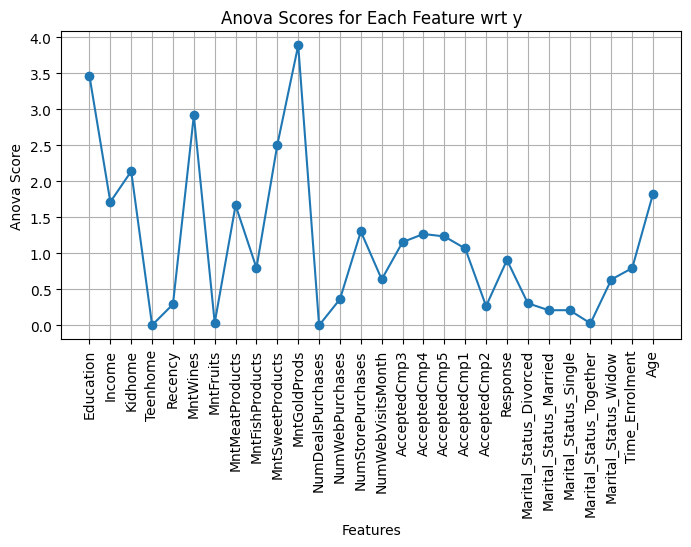

In [97]:
fs = SelectKBest(score_func=f_classif, k=k)
# fs = SelectKBest(score_func= mutual_info_classif, k=k)
fs.fit_transform(X_train, y_train)
plotScores(fs.scores_, 'Anova')

In [98]:
# Get the scores and feature indices
scores = fs.scores_
indices = fs.get_support(indices=True)

for i in indices:
    print(f"{X_train.columns[i]}: {scores[i]}")

# Print the indices of selected features
print("\nSelected feature indices:", indices)

Education: 3.4612051350883624
Income: 1.7127322941726275
Kidhome: 2.1378805125778837
MntWines: 2.9136179622270073
MntMeatProducts: 1.6659115691542825
MntFishProducts: 0.7966243289151389
MntSweetProducts: 2.5067247759662257
MntGoldProds: 3.8864581879924907
NumStorePurchases: 1.3030439059060126
AcceptedCmp3: 1.1556109549736022
AcceptedCmp4: 1.2679805093606498
AcceptedCmp5: 1.2341152084475275
AcceptedCmp1: 1.066763996871083
Response: 0.9062686597522411
Age: 1.8297366240490547

Selected feature indices: [ 0  1  2  5  7  8  9 10 13 15 16 17 18 20 27]


In [99]:
# applying best k features to training and testing set
X_test = X_test.iloc[:, indices]
X_train = X_train.iloc[:, indices]

## PART A

#### Single Decision Tree

In [100]:
cols = ['Training Data', 'Precision', 'Recall', 'Accuracy']
performance_arr = []
# decision tree, random forest, Gradient Boosting Ensemble, SVM, MLP, kNN
for i in range(6):
  performance_arr.append(pd.DataFrame(columns=cols))

In [101]:
def addToPerformanceDf(idx, p, r, c, data='Original'):
  pdf = performance_arr[idx]
  row = {'Training Data': data, 'Precision': f'{p:.2f}', 'Recall': f'{r:.2f}', 'Accuracy': f'{a:.2f}'}
  pdf.loc[len(pdf)] = row
  performance_arr[idx] = pdf

In [102]:
class ModelBase:
  def __init__(self, model, xtrain, xtest, ytrain, ytest):
    self.__xtrain = xtrain
    self.__ytrain = ytrain
    self.__xtest = xtest
    self.__ytest = ytest
    self.__model = model

  def train(self):
    self.__model.fit(self.__xtrain, self.__ytrain)

  def predict(self):
    self.__ypred = self.__model.predict(self.__xtest)
    return self.__ypred

  def plot_roc_curve(self):
    roc_auc, fpr, tpr = self.calculate_roc()
    # Plot ROC curve
    plt.figure(figsize=(4, 3))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

  def calculate_roc(self):
    # Get predicted probabilities for the positive class
    y_prob = self.__model.predict_proba(self.__xtest)[:, 1]
    # Compute ROC curve and area under the curve (AUC)
    fpr, tpr, thresholds = roc_curve(self.__ytest, y_prob)
    roc_auc = auc(fpr, tpr)
    return roc_auc, fpr, tpr

  def model_evaluation(self):
    recall = recall_score(self.__ytest, self.__ypred)
    precision = precision_score(self.__ytest, self.__ypred)
    accuracy = accuracy_score(self.__ytest, self.__ypred)
    print(f"Precision: {precision:.2f}\nRecall: {recall:.2f}\nAccuracy: {accuracy:.2f}\n")
    # Additional metrics
    print("Classification Report:\n", classification_report(self.__ytest, self.__ypred))
    conf_matrix = confusion_matrix(self.__ytest, self.__ypred)
    plt.figure(figsize=(3, 2))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
    plt.show()
    return recall, precision, accuracy

In [103]:
class SingleDecisionTree(ModelBase):
  def __init__(self, xtrain, xtest, ytrain, ytest):
    super().__init__(DecisionTreeClassifier(), xtrain, xtest, ytrain, ytest)

In [104]:
dt_model_1 = SingleDecisionTree(X_train, X_test, y_train, y_test)
dt_model_1.train()
y_pred = dt_model_1.predict()

Precision: 0.25
Recall: 0.40
Accuracy: 0.98

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       549
           1       0.25      0.40      0.31         5

    accuracy                           0.98       554
   macro avg       0.62      0.69      0.65       554
weighted avg       0.99      0.98      0.99       554



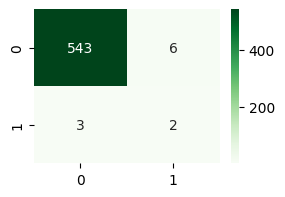

In [105]:
r, p, a = dt_model_1.model_evaluation()
addToPerformanceDf(0, r, p, a)

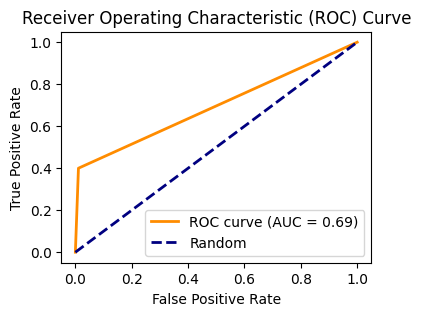

In [106]:
dt_model_1.plot_roc_curve()

In [107]:
# # Define the parameter grid to search
# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [5, 10, 15],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

In [108]:
# # Use StratifiedKFold for classification tasks
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# ## WHAT PARAM SHOULD WE USE TO EVALUATE HYPERPARAMETERS ???

# # Create a GridSearchCV object
# grid_search = GridSearchCV(dt_classifier, param_grid, cv=cv, scoring='accuracy')

# # Fit the GridSearchCV object to the data
# grid_search.fit(X, y)

In [109]:
# After fitting a GridSearchCV instance in scikit-learn, you can access various attributes and methods to analyze and extract information about the best model and its performance. Here are some common steps to take after fitting a GridSearchCV:

# Best Parameters:
# Retrieve the best hyperparameters found by the grid search.

# python
# Copy code
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)
# Best Estimator:
# Get the best estimator (model) that resulted from the grid search.

# python
# Copy code
# best_model = grid_search.best_estimator_
# Best Score:
# Obtain the best cross-validated score associated with the best parameters.

# python
# Copy code
# best_score = grid_search.best_score_
# print("Best Cross-validated Score:", best_score)
# Detailed Results:
# Access detailed information about the grid search results, including mean and standard deviation of the cross-validated scores for each combination of hyperparameters.

# python
# Copy code
# cv_results = grid_search.cv_results_
# Feature Importances (if applicable):
# If your model has feature importances (e.g., for tree-based models), you can extract them.

# python
# Copy code
# if hasattr(best_model, 'feature_importances_'):
#     feature_importances = best_model.feature_importances_
# Predictions on New Data:
# Use the best model to make predictions on new data.

# python
# Copy code
# y_pred = best_model.predict(X_new)
# Model Evaluation:
# Evaluate the model performance on the test set or other data not used during the training and cross-validation.

# python
# Copy code
# test_score = best_model.score(X_test, y_test)
# These steps will help you extract information about the best model and its performance. Choose the steps that are most relevant to your specific use case and analysis goals.

#### Random Forest Classifier

In [110]:
class RandomForest(ModelBase):
  def __init__(self, xtrain, xtest, ytrain, ytest, n=100):
    super().__init__(RandomForestClassifier(n_estimators=n, random_state=42), xtrain, xtest, ytrain, ytest)

In [111]:
rf_model_1 = RandomForest(X_train, X_test, y_train, y_test, 100)
rf_model_1.train()
y_pred = rf_model_1.predict()

Precision: 1.00
Recall: 0.20
Accuracy: 0.99

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       549
           1       1.00      0.20      0.33         5

    accuracy                           0.99       554
   macro avg       1.00      0.60      0.66       554
weighted avg       0.99      0.99      0.99       554



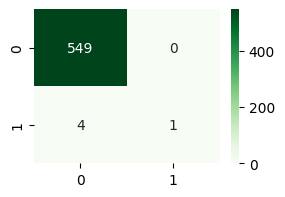

In [112]:
r, p, a = rf_model_1.model_evaluation()
addToPerformanceDf(1, r, p, a)

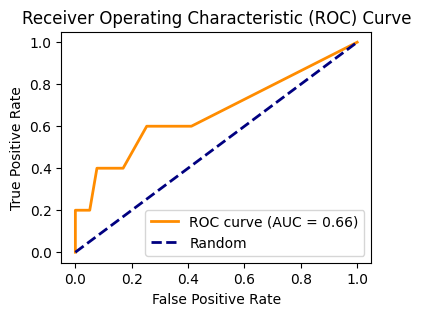

In [113]:
rf_model_1.plot_roc_curve()

#### SVM (Support Vector Machine)

#### Gradient Boosting Ensemble

In [114]:
class GBEnsemble(ModelBase):
  def __init__(self, xtrain, xtest, ytrain, ytest, n=100, lr=0.1):
    super().__init__(GradientBoostingClassifier(n_estimators=n, learning_rate=lr, random_state=42), xtrain, xtest, ytrain, ytest)

In [115]:
gbe_model_1 = GBEnsemble(X_train, X_test, y_train, y_test, 100, 0.1)
gbe_model_1.train()
y_pred = gbe_model_1.predict()

Precision: 0.25
Recall: 0.20
Accuracy: 0.99

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       549
           1       0.25      0.20      0.22         5

    accuracy                           0.99       554
   macro avg       0.62      0.60      0.61       554
weighted avg       0.99      0.99      0.99       554



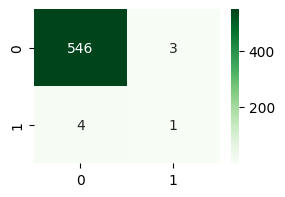

In [116]:
r, p, a = gbe_model_1.model_evaluation()
addToPerformanceDf(3, r, p, a)

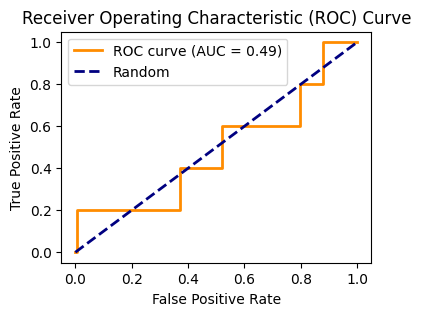

In [117]:
gbe_model_1.plot_roc_curve()

#### MLP (Multi Layer Perceptron)

In [118]:
class MLP(ModelBase):
  def __init__(self, xtrain, xtest, ytrain, ytest, hl_size=(50,50), itr=500):
    super().__init__(MLPClassifier(hidden_layer_sizes=hl_size, max_iter=itr, random_state=42), xtrain, xtest, ytrain, ytest)

In [119]:
mlp_model_1 = MLP(X_train, X_test, y_train, y_test, (50,50), 500)
mlp_model_1.train()
y_pred = mlp_model_1.predict()

Precision: 0.00
Recall: 0.00
Accuracy: 0.99

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       549
           1       0.00      0.00      0.00         5

    accuracy                           0.99       554
   macro avg       0.50      0.50      0.50       554
weighted avg       0.98      0.99      0.99       554



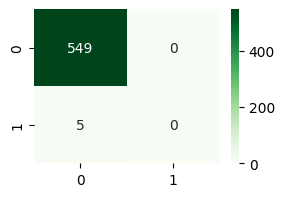

In [120]:
r, p, a = mlp_model_1.model_evaluation()
addToPerformanceDf(4, r, p, a)

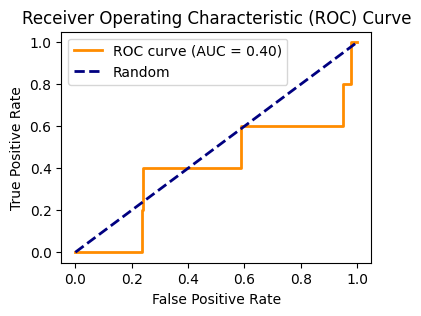

In [121]:
mlp_model_1.plot_roc_curve()

#### kNN (k-Nearest Neighbors)

In [122]:
class KNN(ModelBase):
  def __init__(self, xtrain, xtest, ytrain, ytest, n=3):
    super().__init__(KNeighborsClassifier(n_neighbors=n), xtrain, xtest, ytrain, ytest)

In [123]:
knn_model_1 = KNN(X_train, X_test, y_train, y_test, 3)
knn_model_1.train()
y_pred = knn_model_1.predict()

Precision: 0.00
Recall: 0.00
Accuracy: 0.99

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       549
           1       0.00      0.00      0.00         5

    accuracy                           0.99       554
   macro avg       0.50      0.50      0.50       554
weighted avg       0.98      0.99      0.99       554



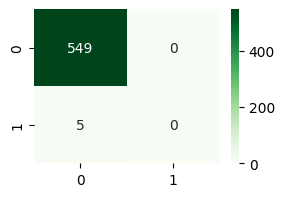

In [124]:
r, p, a = knn_model_1.model_evaluation()
addToPerformanceDf(5, r, p, a)

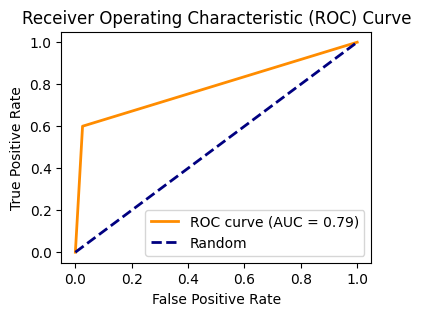

In [125]:
knn_model_1.plot_roc_curve()

## PART B

#### Undersampling

In [161]:
# X_train_reset = X_train.reset_index(drop=True)
# y_train_reset = y_train.reset_index(drop=True)
# train_data = X_train_reset.copy()
# train_data['Complain'] = y_train_reset

In [162]:
# Instantiate RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)

# Fit and apply the random under-sampling
X_us, y_us = rus.fit_resample(X_train, y_train)

In [163]:
print("Undersampled X shape = ", X_us.shape)
print("Undersampled y shape = ", y_us.shape)

Undersampled X shape =  (32, 15)
Undersampled y shape =  (32,)


In [164]:
dt_model_2 = SingleDecisionTree(X_us, X_test, y_us, y_test)
dt_model_2.train()
y_pred = dt_model_2.predict()

In [165]:
rf_model_2 = RandomForest(X_us, X_test, y_us, y_test, 100)
rf_model_2.train()
y_pred = rf_model_2.predict()

In [166]:
gbe_model_2 = GBEnsemble(X_us, X_test, y_us, y_test, 100, 0.1)
gbe_model_2.train()
y_pred = gbe_model_2.predict()

In [167]:
mlp_model_2 = MLP(X_us, X_test, y_us, y_test, (50,50), 500)
mlp_model_2.train()
y_pred = mlp_model_2.predict()

In [168]:
knn_model_2 = KNN(X_us, X_test, y_us, y_test, 3)
knn_model_2.train()
y_pred = knn_model_2.predict()

Decision Tree Evaluation: 



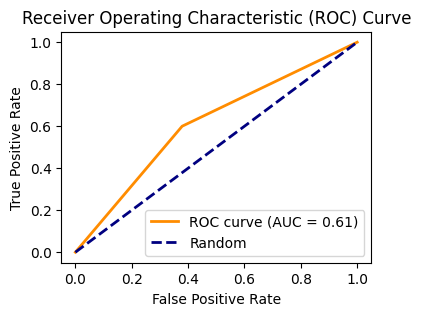

Precision: 0.01
Recall: 0.60
Accuracy: 0.62

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.62      0.76       549
           1       0.01      0.60      0.03         5

    accuracy                           0.62       554
   macro avg       0.50      0.61      0.40       554
weighted avg       0.99      0.62      0.76       554



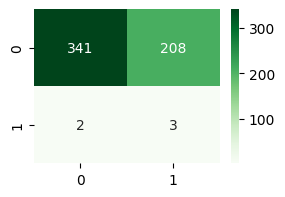

In [169]:
print("Decision Tree Evaluation: \n")
dt_model_2.plot_roc_curve()
r, p, a = dt_model_2.model_evaluation()
addToPerformanceDf(0, r, p, a, 'Undersampled')

Random Forest Evaluation: 

Precision: 0.01
Recall: 0.60
Accuracy: 0.53

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.53      0.69       549
           1       0.01      0.60      0.02         5

    accuracy                           0.53       554
   macro avg       0.50      0.57      0.36       554
weighted avg       0.98      0.53      0.69       554



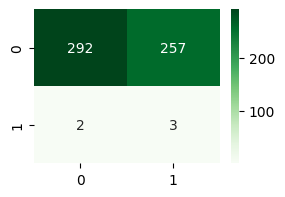

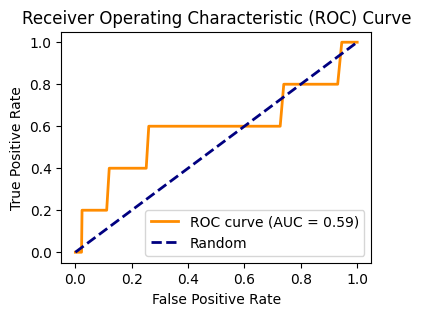

In [170]:
print("Random Forest Evaluation: \n")
r, p, a = rf_model_2.model_evaluation()
rf_model_2.plot_roc_curve()
addToPerformanceDf(1, r, p, a, 'Undersampled')

Gradient Boosting Ensemble Evaluation: 

Precision: 0.01
Recall: 0.60
Accuracy: 0.59

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.59      0.74       549
           1       0.01      0.60      0.03         5

    accuracy                           0.59       554
   macro avg       0.50      0.60      0.38       554
weighted avg       0.99      0.59      0.74       554



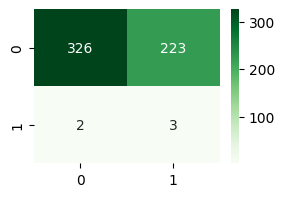

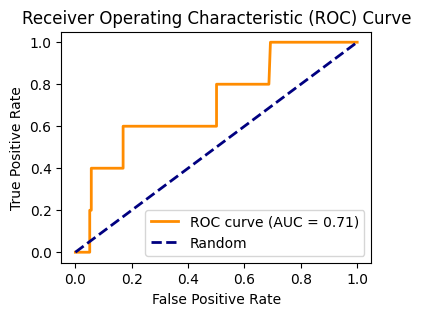

In [171]:
print("Gradient Boosting Ensemble Evaluation: \n")
r, p, a = gbe_model_2.model_evaluation()
gbe_model_2.plot_roc_curve()
addToPerformanceDf(3, r, p, a, 'Undersampled')

MLP Evaluation: 

Precision: 0.01
Recall: 0.60
Accuracy: 0.63

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.63      0.77       549
           1       0.01      0.60      0.03         5

    accuracy                           0.63       554
   macro avg       0.50      0.61      0.40       554
weighted avg       0.99      0.63      0.76       554



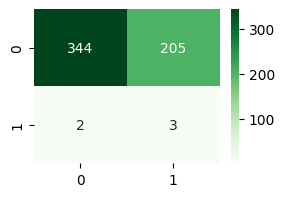

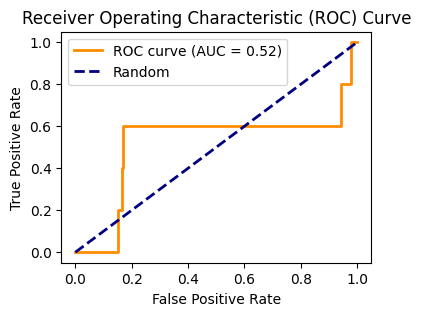

In [172]:
print("MLP Evaluation: \n")
r, p, a = mlp_model_2.model_evaluation()
mlp_model_2.plot_roc_curve()
addToPerformanceDf(4, r, p, a, 'Undersampled')

k-NN Evaluation: 

Precision: 0.01
Recall: 0.60
Accuracy: 0.55

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.55      0.71       549
           1       0.01      0.60      0.02         5

    accuracy                           0.55       554
   macro avg       0.50      0.58      0.37       554
weighted avg       0.98      0.55      0.70       554



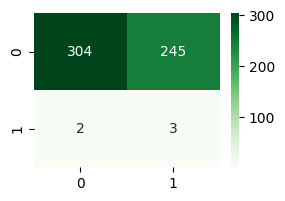

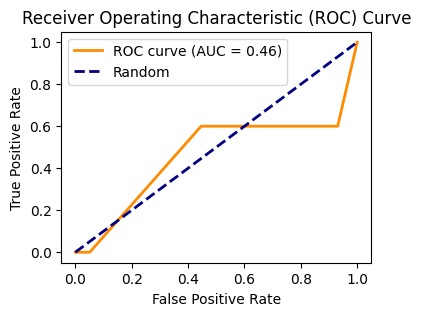

In [173]:
print("k-NN Evaluation: \n")
r, p, a = knn_model_2.model_evaluation()
knn_model_2.plot_roc_curve()
addToPerformanceDf(5, r, p, a, 'Undersampled')

#### Oversampling

In [174]:
# Instantiate SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Fit and apply SMOTE over-sampling
X_os, y_os = smote.fit_resample(X_train, y_train)

In [175]:
print("Oversampled X shape = ", X_os.shape)
print("Oversampled y shape = ", y_os.shape)

Oversampled X shape =  (3292, 15)
Oversampled y shape =  (3292,)


In [176]:
dt_model_3 = SingleDecisionTree(X_os, X_test, y_os, y_test)
dt_model_3.train()
y_pred = dt_model_3.predict()

In [177]:
rf_model_3 = RandomForest(X_os, X_test, y_os, y_test, 100)
rf_model_3.train()
y_pred = rf_model_3.predict()

In [178]:
gbe_model_3 = GBEnsemble(X_os, X_test, y_os, y_test, 100, 0.1)
gbe_model_3.train()
y_pred = gbe_model_3.predict()

In [179]:
mlp_model_3 = MLP(X_os, X_test, y_os, y_test, (50,50), 500)
mlp_model_3.train()
y_pred = mlp_model_3.predict()

In [180]:
knn_model_3 = KNN(X_os, X_test, y_os, y_test, 3)
knn_model_3.train()
y_pred = knn_model_3.predict()

Decision Tree Evaluation: 

Precision: 0.05
Recall: 0.20
Accuracy: 0.96

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       549
           1       0.05      0.20      0.08         5

    accuracy                           0.96       554
   macro avg       0.52      0.58      0.53       554
weighted avg       0.98      0.96      0.97       554



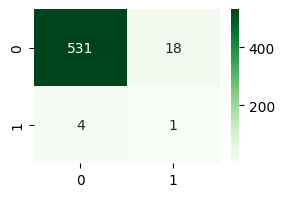

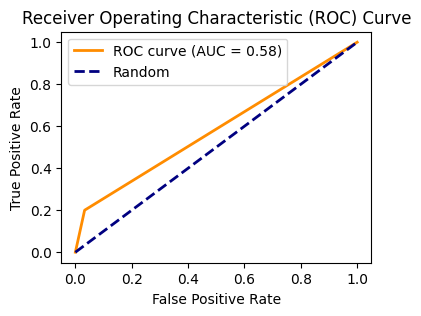

In [181]:
print("Decision Tree Evaluation: \n")
r, p, a = dt_model_3.model_evaluation()
dt_model_3.plot_roc_curve()
addToPerformanceDf(0, r, p, a, 'Oversampled')

Random Forest Evaluation: 

Precision: 0.50
Recall: 0.20
Accuracy: 0.99

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       549
           1       0.50      0.20      0.29         5

    accuracy                           0.99       554
   macro avg       0.75      0.60      0.64       554
weighted avg       0.99      0.99      0.99       554



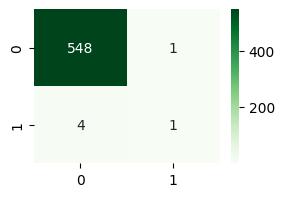

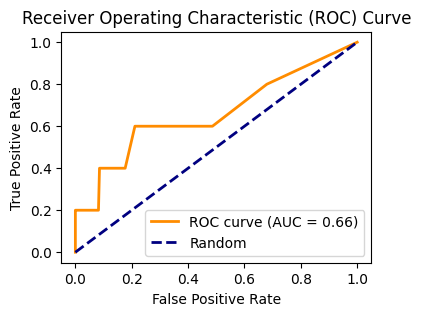

In [182]:
print("Random Forest Evaluation: \n")
r, p, a = rf_model_3.model_evaluation()
rf_model_3.plot_roc_curve()
addToPerformanceDf(1, r, p, a, 'Oversampled')

Gradient Boosting Ensemble Evaluation: 

Precision: 0.00
Recall: 0.00
Accuracy: 0.96

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       549
           1       0.00      0.00      0.00         5

    accuracy                           0.96       554
   macro avg       0.50      0.49      0.49       554
weighted avg       0.98      0.96      0.97       554



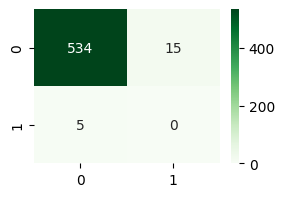

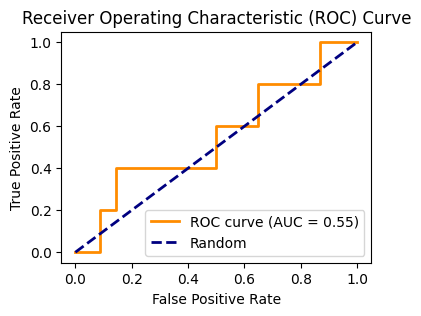

In [183]:
print("Gradient Boosting Ensemble Evaluation: \n")
r, p, a = gbe_model_3.model_evaluation()
gbe_model_3.plot_roc_curve()
addToPerformanceDf(3, r, p, a, 'Oversampled')

MLP Evaluation: 

Precision: 0.07
Recall: 0.20
Accuracy: 0.97

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       549
           1       0.07      0.20      0.11         5

    accuracy                           0.97       554
   macro avg       0.53      0.59      0.54       554
weighted avg       0.98      0.97      0.98       554



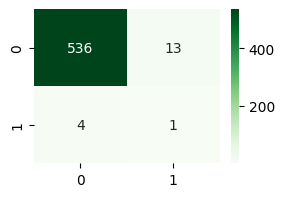

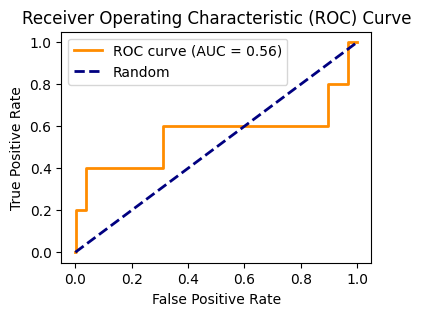

In [184]:
print("MLP Evaluation: \n")
r, p, a = mlp_model_3.model_evaluation()
mlp_model_3.plot_roc_curve()
addToPerformanceDf(4, r, p, a, 'Oversampled')

k-NN Evaluation: 

Precision: 0.12
Recall: 0.60
Accuracy: 0.96

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       549
           1       0.12      0.60      0.20         5

    accuracy                           0.96       554
   macro avg       0.56      0.78      0.59       554
weighted avg       0.99      0.96      0.97       554



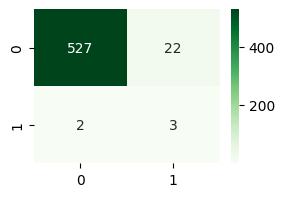

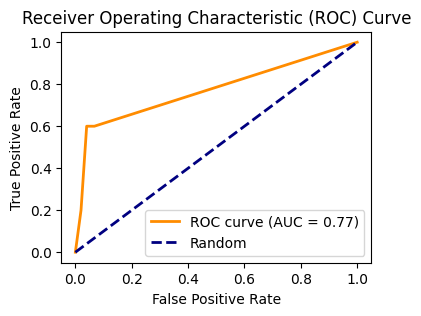

In [185]:
print("k-NN Evaluation: \n")
r, p, a = knn_model_3.model_evaluation()
knn_model_3.plot_roc_curve()
addToPerformanceDf(5, r, p, a, 'Oversampled')

## Results

In [186]:
performance_arr[0].head()

,Training Data,Precision,Recall,Accuracy
0,Original,0.40,0.25,0.98
1,Original,0.60,0.01,0.58
2,Original,0.20,0.05,0.96
3,Undersampled,0.60,0.01,0.62
4,Oversampled,0.20,0.05,0.96


In [187]:
performance_arr[1].head()

,Training Data,Precision,Recall,Accuracy
0,Original,0.20,1.00,0.99
1,Original,0.60,0.01,0.53
2,Original,0.20,0.50,0.99
3,Undersampled,0.60,0.01,0.53
4,Oversampled,0.20,0.50,0.99


In [188]:
performance_arr[2].head()

,Training Data,Precision,Recall,Accuracy


In [189]:
performance_arr[3].head()

,Training Data,Precision,Recall,Accuracy
0,Original,0.20,0.25,0.99
1,Original,0.60,0.01,0.59
2,Original,0.00,0.00,0.96
3,Undersampled,0.60,0.01,0.59
4,Oversampled,0.00,0.00,0.96


In [190]:
performance_arr[4].head()

,Training Data,Precision,Recall,Accuracy
0,Original,0.00,0.00,0.99
1,Original,0.60,0.01,0.63
2,Original,0.20,0.07,0.97
3,Undersampled,0.60,0.01,0.63
4,Oversampled,0.20,0.07,0.97


In [191]:
performance_arr[5].head()

,Training Data,Precision,Recall,Accuracy
0,Original,0.00,0.00,0.99
1,Original,0.60,0.01,0.55
2,Original,0.60,0.12,0.96
3,Undersampled,0.60,0.01,0.55
4,Oversampled,0.60,0.12,0.96
